# BLM example

In [1]:
# Add PyTwoWay to system path (do not run this)
# import sys
# sys.path.append('../../..')

## Import the PyTwoWay package

Make sure to install it using `pip install pytwoway`.

In [2]:
import numpy as np
import bipartitepandas as bpd
import pytwoway as tw
from pytwoway import constraints as cons
from matplotlib import pyplot as plt

## First, check out parameter options

Do this by running:

- BLM - `tw.blm_params().describe_all()`

- Clustering - `bpd.cluster_params().describe_all()`

- Cleaning - `bpd.clean_params().describe_all()`

- Simulating - `bpd.sim_params().describe_all()`

Alternatively, run `x_params().keys()` to view all the keys for a parameter dictionary, then `x_params().describe(key)` to get a description for a single key.

## Second, set parameter choices

In [3]:
nl = 3 # Number of worker types
nk = 4 # Number of firm types
blm_params = tw.blm_params({
    'nl': nl, 'nk': nk,
    'a1_mu': 0, 'a1_sig': 1.5, 'a2_mu': 0, 'a2_sig': 1.5,
    's1_low': 0.5, 's1_high': 1.5, 's2_low': 0.5, 's2_high': 1.5
})
cluster_params = bpd.cluster_params({
    'measures': bpd.measures.CDFs(),
    'grouping': bpd.grouping.KMeans(n_clusters=nk),
    'is_sorted': True,
    'copy': False
})
clean_params = bpd.clean_params({
    'drop_returns': 'returners',
    'copy': False
})
sim_params = bpd.sim_params({
    'nl': nl, 'nk': nk,
    'alpha_sig': 1, 'psi_sig': 1, 'w_sig': 0.6,
    'c_sort': 0, 'c_netw': 0, 'c_sig': 1
})

## Extract data (we simulate for the example)

`BipartitePandas` contains the class `SimBipartite` which we use here to simulate a bipartite network. If you have your own data, you can import it during this step. Load it as a `Pandas DataFrame` and then convert it into a `BipartitePandas DataFrame` in the next step.

Note that `l` gives the true worker type and `k` gives the true firm type, while `alpha` gives the true worker effect and `psi` gives the true firm effect. We will save these columns separately.

The BLM estimator uses the firm types computed via clustering, which are saved in columns `g1` and `g2`.

In [4]:
sim_data = bpd.SimBipartite(sim_params).simulate()

## Prepare data

This is exactly how you should prepare real data prior to running the BLM estimator.

- First, we convert the data into a `BipartitePandas DataFrame`

- Second, we clean the data (e.g. drop NaN observations, make sure firm and worker ids are contiguous, etc.)

- Third, we cluster firms by their wage distributions, to generate firm classes (columns `g1` and `g2`). Alternatively, manually set the columns `g1` and `g2` to pre-estimated clusters (but make sure to [add them correctly!](https://tlamadon.github.io/bipartitepandas/notebooks/custom_columns.html#Adding-custom-columns-to-an-instantiated-DataFrame)).

- Fourth, we collapse the data at the worker-firm spell level (taking mean wage over the spell)

- Fifth, we convert the data into event study format

Further details on `BipartitePandas` can be found in the package documentation, available [here](https://tlamadon.github.io/bipartitepandas/).

In [5]:
# Convert into BipartitePandas DataFrame
sim_data = bpd.BipartiteDataFrame(sim_data)
# Clean and collapse
sim_data = sim_data.clean(clean_params).collapse(is_sorted=True, copy=False)
# Cluster
sim_data = sim_data.cluster(cluster_params)
# Convert to event study format
sim_data = sim_data.to_eventstudy(is_sorted=True, copy=False)

checking required columns and datatypes
sorting rows
dropping NaN observations
generating 'm' column
keeping highest paying job for i-t (worker-year) duplicates (how='max')
dropping workers who leave a firm then return to it (how='returners')
making 'i' ids contiguous
making 'j' ids contiguous
computing largest connected set (how=None)
sorting columns
resetting index


## Separate observed and unobserved data

Some of the simulated data is not observed, so we separate out that data during estimation.

In [6]:
sim_data_observed = sim_data.loc[:, ['i', 'j1', 'j2', 'y1', 'y2', 't11', 't12', 't21', 't22', 'g1', 'g2', 'w1', 'w2', 'm']]
sim_data_unobserved = sim_data.loc[:, ['alpha1', 'alpha2', 'k1', 'k2', 'l1', 'l2', 'psi1', 'psi2']]

## Separate movers and stayers data

We need to distinguish movers and stayers for the estimator.

In [7]:
movers = sim_data_observed.get_worker_m(is_sorted=True)
jdata = sim_data_observed.loc[movers, :]
sdata = sim_data_observed.loc[~movers, :]

## Check the data

Let's check the cleaned data.

In [8]:
print('Movers data')
display(jdata)
print('Stayers data')
display(sdata)

Movers data


,i,j1,j2,y1,y2,t11,t12,t21,t22,g1,g2,w1,w2,m
0,0,189,141,0.658481,-0.302737,0,0,1,3,0,3,1,3,1
1,0,141,179,-0.302737,-0.070679,1,3,4,4,3,0,3,1,1
2,1,3,178,-0.977635,-0.138164,0,0,1,4,1,0,1,4,1
3,2,179,9,0.273751,-2.872666,0,2,3,3,0,1,3,1,1
4,2,9,113,-2.872666,-1.395046,3,3,4,4,1,3,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20331,9923,5,18,-2.439280,-2.086203,0,0,1,1,1,1,1,1,1
20332,9923,18,186,-2.086203,0.518828,1,1,2,2,1,0,1,1,1
20333,9923,186,92,0.518828,0.440968,2,2,3,3,0,2,1,1,1
20334,9923,92,14,0.440968,-1.070705,3,3,4,4,2,1,1,1,1


Stayers data


,i,j1,j2,y1,y2,t11,t12,t21,t22,g1,g2,w1,w2,m
16,9,183,183,1.775003,1.775003,0,4,0,4,0,0,5,5,0
101,55,36,36,-0.154698,-0.154698,0,4,0,4,1,1,5,5,0
127,65,192,192,0.476397,0.476397,0,4,0,4,0,0,5,5,0
131,67,123,123,-0.268389,-0.268389,0,4,0,4,3,3,5,5,0
152,78,15,15,-0.318783,-0.318783,0,4,0,4,1,1,5,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20111,9820,177,177,0.865980,0.865980,0,4,0,4,0,0,5,5,0
20155,9840,111,111,1.149045,1.149045,0,4,0,4,3,3,5,5,0
20213,9866,187,187,1.390672,1.390672,0,4,0,4,0,0,5,5,0
20259,9885,17,17,-1.266577,-1.266577,0,4,0,4,1,1,5,5,0


## Initialize and run BLMEstimator

<div class="alert alert-info">

Note

The `BLMEstimator` class requires data to be formatted as a BipartitePandas DataFrame.

</div>

In [ ]:
# Initialize BLM estimator
blm_fit = tw.BLMEstimator(blm_params)
# Fit BLM estimator
blm_fit.fit(jdata=jdata, sdata=sdata, n_init=40, n_best=5, ncore=8)
# Store best model
blm_model = blm_fit.model

## Check that log-likelihoods are monotonic

Log-likelihoods monotonic (movers): True


Text(0, 0.5, 'Change in log-likelihood')

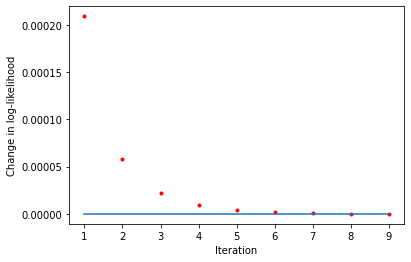

In [10]:
liks1 = blm_model.liks1

print('Log-likelihoods monotonic (movers):', np.min(np.diff(liks1)) >= 0)

x_axis = range(1, len(liks1))
plt.plot(x_axis, np.diff(liks1), '.', label='liks1', color='red')
plt.plot(x_axis, np.zeros(len(liks1) - 1))
plt.xlabel('Iteration')
plt.ylabel('Change in log-likelihood')

Log-likelihoods monotonic (stayers): True


Text(0, 0.5, 'Change in log-likelihood')

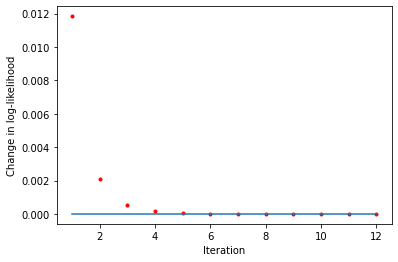

In [11]:
liks0 = blm_model.liks0

print('Log-likelihoods monotonic (stayers):', np.min(np.diff(liks0)) >= 0)

x_axis = range(1, len(liks0))
plt.plot(x_axis, np.diff(liks0), '.', label='liks0', color='red')
plt.plot(x_axis, np.zeros(len(liks0) - 1))
plt.xlabel('Iteration')
plt.ylabel('Change in log-likelihood')

## Now we can investigate the results

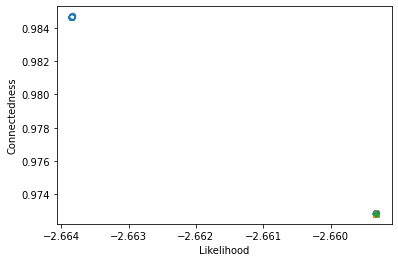

In [12]:
# Plot likelihood vs. connectedness
blm_fit.plot_liks_connectedness()

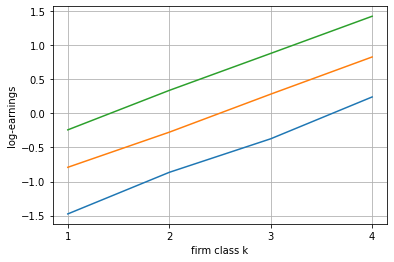

In [13]:
blm_fit.plot_log_earnings()

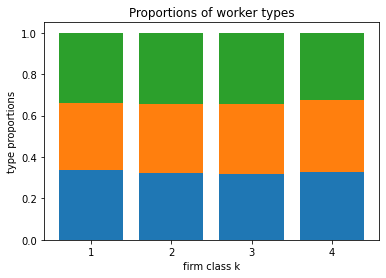

In [14]:
blm_fit.plot_type_proportions()

## Finally, we can compare estimates to the truth

In [15]:
# Compute true parameters
true_A1 = np.expand_dims(sim_data_unobserved.groupby('l1')['alpha1'].mean().to_numpy(), 1) + np.tile(sim_data_unobserved.groupby('k1')['psi1'].mean().to_numpy(), (nl, 1))
true_A2 = np.expand_dims(sim_data_unobserved.groupby('l2')['alpha2'].mean().to_numpy(), 1) + np.tile(sim_data_unobserved.groupby('k2')['psi2'].mean().to_numpy(), (nl, 1))

# Sort estimated parameters (this is because the firm type order generated by clustering is random - this is automatically handled in the built-in plotting functions)
A1, A2 = blm_model._sort_parameters(blm_model.A1, blm_model.A2, sort_firm_types=True)

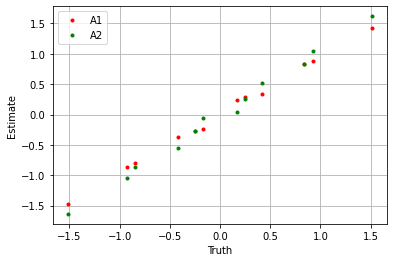

In [16]:
plt.plot(true_A1.flatten(), A1.flatten(), '.', label='A1', color='red')
plt.plot(true_A2.flatten(), A2.flatten(), '.', label='A2', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

## Bootstrapped errors

The package contains the class `BLMBootstrap`, which allows for the construction of bootstrapped error bars.

In this example, we use the same simulated data and estimation parameters as in the previous example.

In [ ]:
# Initialize BLM bootstrap estimator
blm_fit = tw.BLMBootstrap(blm_params)
# Fit BLM estimator
blm_fit.fit(
    jdata=jdata, sdata=sdata,
    blm_model=blm_model,
    n_samples=20,
    cluster_params=cluster_params,
    ncore=8,
    verbose=False
)

## Now we can investigate the results

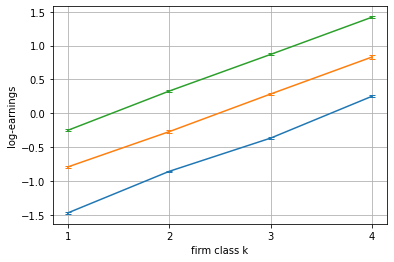

In [18]:
blm_fit.plot_log_earnings()

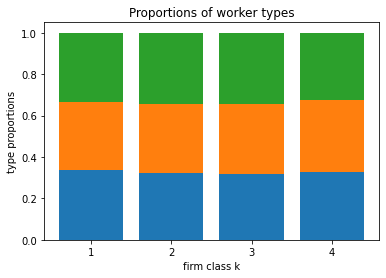

In [19]:
blm_fit.plot_type_proportions()

## Control variables

<div class="alert alert-info">

Hint

Check out how to add custom columns to your BipartitePandas DataFrame [here](https://tlamadon.github.io/bipartitepandas/notebooks/custom_columns.html#)! If you don't add custom columns properly, they may not be handled during data cleaning and estimation how you want and/or expect!

</div>

## Simulating data with controls

The package contains functions to simulate data from the BLM dgp. We use this here to see how to use control variables.

In this example, we simulate a categorical, non-stationary, non-worker-type-interaction control variable. We use a low variance to ensure stability of the estimator.

## Check out simulation parameter options

Do this by running:

- Simulating Categorical Controls - `tw.sim_categorical_control_params().describe_all()`

- Simulating Continuous Controls - `tw.sim_continuous_control_params().describe_all()`

Alternatively, run `x_params().keys()` to view all the keys for a parameter dictionary, then `x_params().describe(key)` to get a description for a single key.

## Set simulation parameter choices

In [20]:
n_control = 2 # Number of types for control variable

sim_cat_params = tw.sim_categorical_control_params({
    'n': n_control,
    'stationary_A': False, 'stationary_S': False,
    'worker_type_interaction': False,
    'a1_mu': -0.5, 'a1_sig': 0.25, 'a2_mu': 0.5, 'a2_sig': 0.25,
    's1_low': 0, 's1_high': 0.01, 's2_low': 0, 's2_high': 0.01
})
sim_cts_params = tw.sim_continuous_control_params({
    'stationary_A': True, 'stationary_S': True,
    'worker_type_interaction': True,
    'a1_mu': -0.15, 'a1_sig': 0.05, 'a2_mu': 0.15, 'a2_sig': 0.05,
    's1_low': 0, 's1_high': 0.01, 's2_low': 0, 's2_high': 0.01
})
sim_blm_params = tw.sim_blm_params({
    'nl': nl, 'nk': nk,
    'a1_mu': -2, 'a1_sig': 0.25, 'a2_mu': 2, 'a2_sig': 0.25,
    's1_low': 0, 's1_high': 0.01, 's2_low': 0, 's2_high': 0.01,
    'categorical_controls': {'cat_control': sim_cat_params},
    'continuous_controls': {'cts_control': sim_cts_params}
})

## Estimating control variables

PyTwoWay allows for categorical and continuous control variables.

### Categorical

To define a categorical control variable, construct an instance of the parameter dictionary `tw.categorical_control_params()`.

Then, inside an instance of `blm_params()`, link the key `'categorical_controls'` to a dictionary linking column names to their associated parameter dictionaries.

### Continuous

To define a continuous control variable, construct an instance of the parameter dictionary `tw.continuous_control_params()`.

Then, inside an instance of `blm_params()`, link the key `'continuous_controls'` to a dictionary linking column names to their associated parameter dictionaries.

### Constraints

Constraints can be specified for control variables. They are set through the `cons_a` and `cons_s` keys for a given control variable's parameter dictionary, except for `NoWorkerTypeInteraction()`. Constraint options are:
- `Linear()` - for a fixed firm type, worker types effects must change linearly
- `Monotonic()` - for a fixed firm type, worker types effects must increase (or decrease) monotonically
- `NoWorkerTypeInteraction()` - for a fixed firm type, worker types effects must all be the same
- `Stationary()` - worker-firm pair effects are the same in all periods
- `StationaryFirmTypeVariation()` - firm type induced variation of worker-firm pair effects is the same in all periods. In particular, this is equivalent to setting `A2 = (np.mean(A2, axis=1) + A1.T - np.mean(A1, axis=1)).T`.
- `BoundedBelow()` - worker-firm pair effects are bounded below
- `BoundedAbove()` - worker-firm pair effects are bounded above

`NoWorkerTypeInteraction()` is not specified through the `cons_a` and `cons_s` keys. Instead, if you want a control variable to interact with the unobserved worker types, this can be specified by setting `worker_type_interaction=True` in the control variable's parameter dictionary.

<div class="alert alert-warning">

Warning

Be careful when adding constraints to categorical control variables (note that not interacting with worker types requires constraints). Because categorical control variables require normalization, the choice of how to normalize can alter parameter estimates. This may raise a warning if the normalization gets stuck in a cycle of changing how to normalize every loop and the estimator is not converging. The estimator will work if you set `force_min_firm_type=True` in your BLM parameter dictionary - the warning will also provide a reminder of this option.

</div>

## Check out estimation parameter options

Do this by running:

- Estimating Categorical Controls - `tw.categorical_control_params().describe_all()`

- Estimating Continuous Controls - `tw.continuous_control_params().describe_all()`

Alternatively, run `x_params().keys()` to view all the keys for a parameter dictionary, then `x_params().describe(key)` to get a description for a single key.

## Set estimation parameter choices

In [21]:
cat_params = tw.categorical_control_params({
    'n': n_control,
    'worker_type_interaction': False,
    'cons_a': None, 'cons_s': None,
    'a1_mu': -0.5, 'a1_sig': 0.25, 'a2_mu': 0.5, 'a2_sig': 0.25,
    's1_low': 0, 's1_high': 0.01, 's2_low': 0, 's2_high': 0.01
})
cts_params = tw.continuous_control_params({
    'worker_type_interaction': True,
    'cons_a': cons.Stationary(), 'cons_s': cons.Stationary(),
    'a1_mu': -0.15, 'a1_sig': 0.05, 'a2_mu': 0.15, 'a2_sig': 0.05,
    's1_low': 0, 's1_high': 0.01, 's2_low': 0, 's2_high': 0.01
})
blm_params = tw.blm_params({
    'nl': nl, 'nk': nk,
    'a1_mu': -2, 'a1_sig': 0.25, 'a2_mu': 2, 'a2_sig': 0.25,
    's1_low': 0, 's1_high': 0.01, 's2_low': 0, 's2_high': 0.01,
    'categorical_controls': {'cat_control': cat_params},
    'continuous_controls': {'cts_control': cts_params},
    'force_min_firm_type': True
})

## Simulate data

`sim_data` gives a dictionary where the key `'jdata'` gives simulated mover data and the key `'sdata'` gives simulated stayer data.

`sim_params` gives a dictionary that links each type of control variable to the simulated parameter values for that type.

In [22]:
blm_true = tw.SimBLM(sim_blm_params)
sim_data, sim_params = blm_true.simulate(return_parameters=True)
jdata, sdata = sim_data['jdata'], sim_data['sdata']

In [23]:
print('Movers data')
display(jdata)
print('Stayers data')
display(sdata)
print('Simulated parameter values')
display(sim_params)

Movers data


,i,j1,j2,y1,y2,g1,g2,m,cat_control1,cat_control2,cts_control1,cts_control2,l
0,0,0,1,-1.405170,2.884550,0,0,1,0,1,-1.597127,-0.863375,1
1,1,0,1,-2.944559,2.699658,0,0,1,1,1,0.418682,0.439516,1
2,2,1,0,-1.283777,2.810403,0,0,1,0,1,-2.397280,-0.507434,1
3,3,0,1,-2.674142,2.781658,0,0,1,1,1,-1.445132,-0.133028,1
4,4,0,1,-2.810683,2.110046,0,0,1,1,0,-0.464561,1.254681,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,155,7,6,-1.076676,1.609433,3,3,1,0,0,-0.801424,1.277516,2
156,156,6,7,-2.718684,1.932711,3,3,1,1,0,0.094787,-0.568200,0
157,157,6,7,-2.753058,1.655190,3,3,1,1,0,0.292111,1.155452,0
158,158,6,7,-2.889319,2.357755,3,3,1,1,1,1.194183,-0.255207,0


Stayers data


,i,j1,j2,y1,y2,g1,g2,m,cat_control1,cat_control2,cts_control1,cts_control2,l
0,160,0,0,-3.065299,2.939253,0,0,0,1,1,1.280102,-1.276638,1
1,161,1,1,-3.308012,1.882332,0,0,0,1,0,0.673731,0.978745,2
2,162,1,1,-2.048957,2.500295,0,0,0,0,1,0.188291,-0.354548,0
3,163,1,1,-1.647712,3.035064,0,0,0,0,1,0.224408,-1.773956,1
4,164,0,0,-1.753908,2.028478,0,0,0,0,0,-0.307819,0.595909,2
5,165,1,1,-1.838391,3.205352,0,0,0,0,1,-0.034964,-1.680496,2
6,166,0,0,-1.825758,2.394916,0,0,0,0,1,-0.045699,0.869568,2
7,167,0,0,-3.162265,3.055979,0,0,0,1,1,0.174373,-1.324212,2
8,168,0,0,-2.035432,2.368199,0,0,0,0,1,0.227607,0.600801,0
9,169,0,0,-2.933966,2.556052,0,0,0,1,1,0.343777,1.315978,1


Simulated parameter values


{'A1': array([[-2.40434291, -1.93230882, -2.3641309 , -1.81931006],
        [-1.99649895, -1.8539811 , -1.54271365, -1.67049293],
        [-2.21882556, -1.59916272, -1.37328134, -1.69013257]]),
 'A2': array([[1.85490342, 1.97296398, 2.15268324, 1.7112059 ],
        [2.15476764, 1.81388297, 1.90973225, 2.26752212],
        [2.0604013 , 1.90970787, 1.65698835, 1.84848259]]),
 'S1': array([[6.24733520e-03, 3.25013934e-04, 9.95248435e-03, 7.88841644e-03],
        [5.06607130e-04, 5.60070089e-05, 5.12086700e-03, 8.94274499e-03],
        [1.15689335e-03, 3.52890499e-03, 3.17502080e-03, 9.56078356e-03]]),
 'S2': array([[0.00106304, 0.00627278, 0.0096796 , 0.00626775],
        [0.00905057, 0.00542163, 0.00412828, 0.00967574],
        [0.00684023, 0.00786226, 0.00925993, 0.00867167]]),
 'pk1': array([[0.22439344, 0.64001715, 0.13558941],
        [0.30791439, 0.16101403, 0.53107158],
        [0.13470115, 0.14758551, 0.71771334],
        [0.15657995, 0.31968694, 0.5237331 ],
        [0.08722402, 

## Initialize and run BLMEstimator

In [ ]:
# Initialize BLM estimator
blm_fit = tw.BLMEstimator(blm_params)
# Fit BLM estimator
blm_fit.fit(jdata=jdata, sdata=sdata, n_init=80, n_best=5, ncore=8)
# Store best model
blm_model = blm_fit.model

## Check that log-likelihoods are monotonic

Log-likelihoods monotonic (movers): True


Text(0, 0.5, 'Change in log-likelihood')

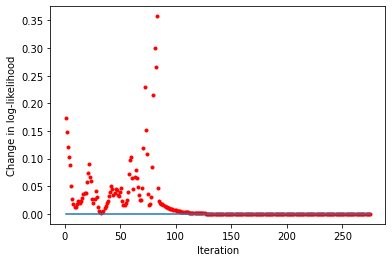

In [25]:
liks1 = blm_model.liks1[1:]

print('Log-likelihoods monotonic (movers):', np.min(np.diff(liks1)) >= 0)

x_axis = range(1, len(liks1))
plt.plot(x_axis, np.diff(liks1), '.', label='liks1', color='red')
plt.plot(x_axis, np.zeros(len(liks1) - 1))
plt.xlabel('Iteration')
plt.ylabel('Change in log-likelihood')

Log-likelihoods monotonic (stayers): True


Text(0, 0.5, 'Change in log-likelihood')

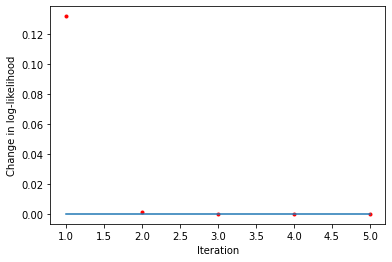

In [26]:
liks0 = blm_model.liks0

print('Log-likelihoods monotonic (stayers):', np.min(np.diff(liks0)) >= 0)

x_axis = range(1, len(liks0))
plt.plot(x_axis, np.diff(liks0), '.', label='liks0', color='red')
plt.plot(x_axis, np.zeros(len(liks0) - 1))
plt.xlabel('Iteration')
plt.ylabel('Change in log-likelihood')

## Now we can investigate the results

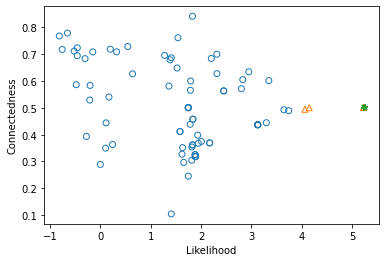

In [27]:
# Plot likelihood vs. connectedness
blm_fit.plot_liks_connectedness()

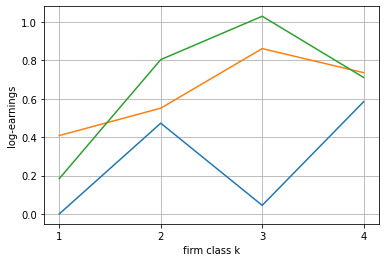

In [28]:
blm_fit.plot_log_earnings()

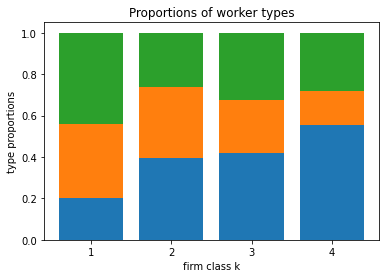

In [29]:
blm_fit.plot_type_proportions()

## Finally, we can compare estimates to the truth

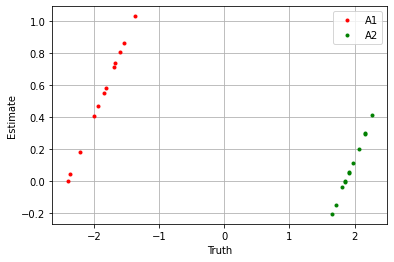

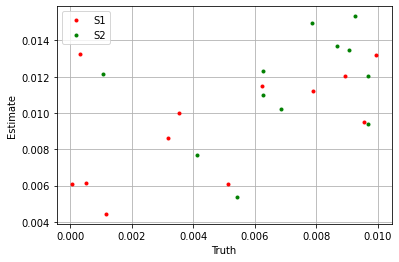

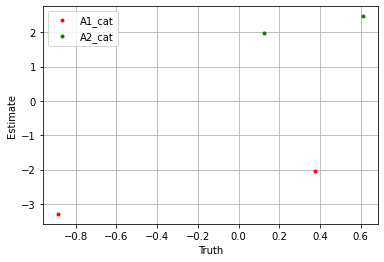

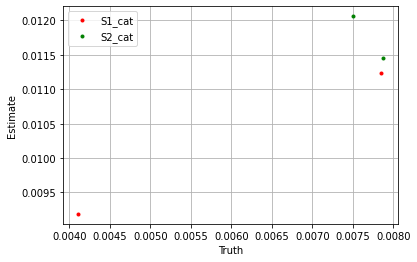

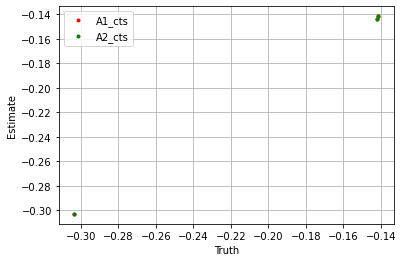

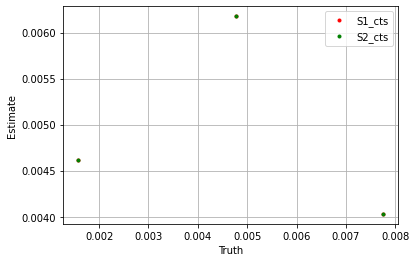

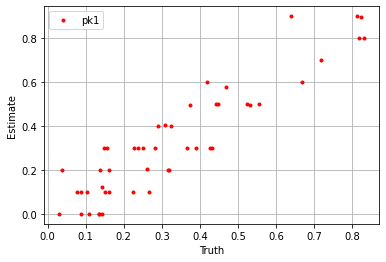

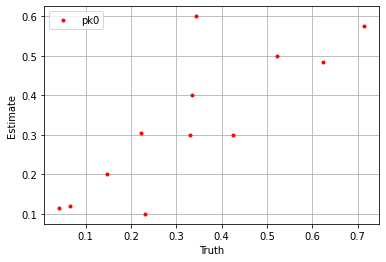

In [30]:
plt.plot(sim_params['A1'].flatten(), blm_model.A1.flatten(), '.', label='A1', color='red')
plt.plot(sim_params['A2'].flatten(), blm_model.A2.flatten(), '.', label='A2', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

plt.plot(sim_params['S1'].flatten(), blm_model.S1.flatten(), '.', label='S1', color='red')
plt.plot(sim_params['S2'].flatten(), blm_model.S2.flatten(), '.', label='S2', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

plt.plot(sim_params['A1_cat']['cat_control'].flatten(), blm_model.A1_cat['cat_control'].flatten(), '.', label='A1_cat', color='red')
plt.plot(sim_params['A2_cat']['cat_control'].flatten(), blm_model.A2_cat['cat_control'].flatten(), '.', label='A2_cat', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

plt.plot(sim_params['S1_cat']['cat_control'].flatten(), blm_model.S1_cat['cat_control'].flatten(), '.', label='S1_cat', color='red')
plt.plot(sim_params['S2_cat']['cat_control'].flatten(), blm_model.S2_cat['cat_control'].flatten(), '.', label='S2_cat', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

plt.plot(sim_params['A1_cts']['cts_control'].flatten(), blm_model.A1_cts['cts_control'].flatten(), '.', label='A1_cts', color='red')
plt.plot(sim_params['A2_cts']['cts_control'].flatten(), blm_model.A2_cts['cts_control'].flatten(), '.', label='A2_cts', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

plt.plot(sim_params['S1_cts']['cts_control'].flatten(), blm_model.S1_cts['cts_control'].flatten(), '.', label='S1_cts', color='red')
plt.plot(sim_params['S2_cts']['cts_control'].flatten(), blm_model.S2_cts['cts_control'].flatten(), '.', label='S2_cts', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

plt.plot(sim_params['pk1'].flatten(), blm_model.pk1.flatten(), '.', label='pk1', color='red')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

plt.plot(sim_params['pk0'].flatten(), blm_model.pk0.flatten(), '.', label='pk0', color='red')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

<div class="alert alert-warning">

Warning

The parameters are identified only up to a constant intercept.

Because of this, to maintain consistency between estimations, PyTwoWay automatically normalizes worker-firm types to have effect 0, depending on the control variables used (normalization only occurs with categorical control variables - for a stationary control variable, only the first period is normalized (if it is non-stationary, both periods are normalized); for a control variable that does not interact with worker types, only the lowest worker type is normalized (if it does interact with worker types, all worker types are normalized)).

If we take the sum over the estimators we see the model performs well.

</div>

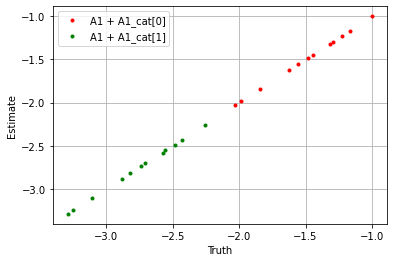

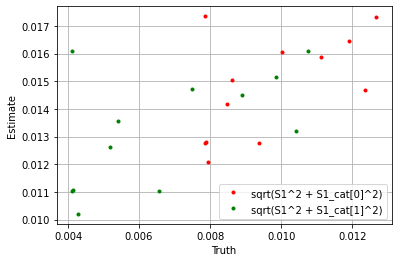

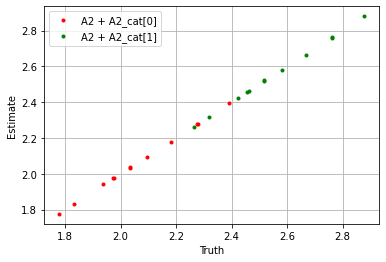

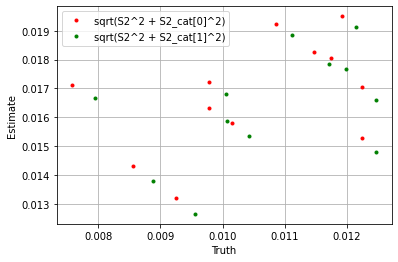

In [31]:
## First period ##
plt.plot(
    (sim_params['A1'] + sim_params['A1_cat']['cat_control'][0]).flatten(),
    (blm_model.A1 + blm_model.A1_cat['cat_control'][0]).flatten(),
    '.', label='A1 + A1_cat[0]', color='red'
)
plt.plot(
    (sim_params['A1'] + sim_params['A1_cat']['cat_control'][1]).flatten(),
    (blm_model.A1 + blm_model.A1_cat['cat_control'][1]).flatten(),
    '.', label='A1 + A1_cat[1]', color='green'
)
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

plt.plot(
    np.sqrt((sim_params['S1'] ** 2 + sim_params['S1_cat']['cat_control'][0] ** 2).flatten()),
    np.sqrt((blm_model.S1 ** 2 + blm_model.S1_cat['cat_control'][0] ** 2).flatten()),
    '.', label='sqrt(S1^2 + S1_cat[0]^2)', color='red'
)
plt.plot(
    np.sqrt((sim_params['S1'] ** 2 + sim_params['S1_cat']['cat_control'][1] ** 2).flatten()),
    np.sqrt((blm_model.S1 ** 2 + blm_model.S1_cat['cat_control'][1] ** 2).flatten()),
    '.', label='sqrt(S1^2 + S1_cat[1]^2)', color='green'
)
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

## Second period ##
plt.plot(
    (sim_params['A2'] + sim_params['A2_cat']['cat_control'][0]).flatten(),
    (blm_model.A2 + blm_model.A2_cat['cat_control'][0]).flatten(),
    '.', label='A2 + A2_cat[0]', color='red'
)
plt.plot(
    (sim_params['A2'] + sim_params['A2_cat']['cat_control'][1]).flatten(),
    (blm_model.A2 + blm_model.A2_cat['cat_control'][1]).flatten(),
    '.', label='A2 + A2_cat[1]', color='green'
)
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

plt.plot(
    np.sqrt((sim_params['S2'] ** 2 + sim_params['S2_cat']['cat_control'][0] ** 2).flatten()),
    np.sqrt((blm_model.S2 ** 2 + blm_model.S2_cat['cat_control'][0] ** 2).flatten()),
    '.', label='sqrt(S2^2 + S2_cat[0]^2)', color='red'
)
plt.plot(
    np.sqrt((sim_params['S2'] ** 2 + sim_params['S2_cat']['cat_control'][1] ** 2).flatten()),
    np.sqrt((blm_model.S2 ** 2 + blm_model.S2_cat['cat_control'][1] ** 2).flatten()),
    '.', label='sqrt(S2^2 + S2_cat[1]^2)', color='green'
)
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.grid()
plt.show()

## Variance decomposition

The package contains the class `BLMVarianceDecomposition`, which allows for the estimation of the decomposition of the variance components of the BLM estimator.

In this example, we use the same simulated data and estimation parameters as in the previous example.

In [ ]:
# Initialize BLM variance decomposition estimator
blm_fit = tw.BLMVarianceDecomposition(blm_params)
# Fit BLM estimator
blm_fit.fit(
    jdata=jdata, sdata=sdata,
    blm_model=blm_model,
    n_samples=20,
    Q_var=[
        tw.Q.VarCovariate('psi'),
        tw.Q.VarCovariate('cat_control'),
        tw.Q.VarCovariate('cts_control')
    ],
    ncore=1
)

### Investigate the results

Results correspond to:

- `y`: income (outcome) column
- `eps`: residual
- `psi`: firm effects
- `alpha`: worker effects

<div class="alert alert-info">

Note

Results from all estimations are stored in the class attribute dictionary `.res`. We take the mean, but storing all results gives the option to estimate different sample statistics.

</div>

<div class="alert alert-info">

Note

The particular variance that is estimated is controlled through the parameter `'Q_var'` and the covariance that is estimated is controlled through the parameter `'Q_cov'`.

By default, the variance is `var(psi)` and the covariance is `cov(psi, alpha)`. The default estimates don't include `var(alpha)`, but if you don't include controls, `var(alpha)` can be computed as the residual from `var(y) = var(psi) + var(alpha) + 2 * cov(psi, alpha) + var(eps)`.

</div>

In [33]:
for k, v in blm_fit.res.items():
    print(f'{k!r}: {v.mean()}')

'var(y)': 4.1784778224072054
'var(eps)': 3.862767039874967
'var(cat_control)': 0.17504851379038694
'var(cts_control)': 0.03529768004099764
'var(psi)': 0.052474105201016495
'cov(psi, alpha)': -0.0014679055738114212
